# Movie Recommender System

## Project Description

This project aims to develop a movie recommendation system that leverages different vectorization methods to represent movies based on their textual content. The focus lies on evaluating and comparing the quality of recommendations generated by these methods, especially regarding their accuracy and runtime performance. The best-performing model will then be integrated into a simple web application to provide practical, content-based movie recommendations.

The project specifically investigates whether detailed plot descriptions improve recommendation accuracy compared to shorter overviews, and how dataset size influences performance.

## Agenda

### Data Preparation and Loading

- Use subsets of movie datasets with 5,000 and 10,000 films to balance experimental runtime and representativeness.
- Focus on two textual sources: short overviews and longer plot descriptions.

### Vectorization Techniques

- Implement and evaluate different text vectorization methods:
  - TF-IDF
  - Word2Vec
  - Sentence-BERT

### Similarity Calculation

- cosine similarity
- HNSW

### Accuracy Calculation

- Top-10 Hit Rate

### Runtime Performance Comparison

- Measure and compare vectorization and similarity search times across methods and dataset sizes.

### Hyperparameter Tuning

- Optimize critical hyperparameters for each vectorization approach to improve recommendation accuracy.

### Genre-based Embedding Analysis

- Apply dimensionality reduction (t-SNE) on Sentence-BERT embeddings.
- Visualize and interpret genre clustering to assess semantic coherence in the vector space.

### Correlation Analysis of Additional Numeric Features

- Investigate correlations between numerical movie attributes (popularity, budget, revenue, runtime, ratings) of original and recommended films.
- Evaluate whether incorporating these features could improve recommendations.

### Web Application Development

- Build a Flask-based web app that allows users to select a movie and receive content-based recommendations using the best model.
- Use the longer plot descriptions as input for the model due to better empirical performance.

## Objective

The project seeks to determine the effectiveness of content-based recommendation approaches relying on textual movie descriptions, with a particular focus on:

- The impact of vectorization method and text length on recommendation quality.
- The trade-off between accuracy and runtime performance.
- Practical feasibility through deployment in a user-facing web application.


In [2]:
import os
import time
import random
from threading import Thread
from itertools import product

import webbrowser
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import torch
from tqdm import tqdm
from flask import Flask, render_template, request
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric, remove_stopwords
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import hnswlib
import plotly.express as px

# TQDM deaktivieren für finaler Notebook Ausführung
tqdm.tqdm = lambda x=None, *args, **kwargs: x if x is not None else iter([])

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Vectorizer

To develop an effective recommender system, it is essential to represent movies in a form that can be processed and compared algorithmically. For this purpose, movie descriptions are transformed into numerical vectors. This vectorization forms the foundation for all subsequent steps, such as similarity calculation and recommendation generation.

This project explores and compares three different approaches to text vectorization, each varying in complexity and semantic representation.

The first approach is TF-IDF (Term Frequency – Inverse Document Frequency), a classic, purely statistical method that assigns weights to terms based on their frequency. Words that appear frequently in a single document receive a higher weight, while words that appear across many documents are down-weighted. TF-IDF is simple to compute and interpret, making it well-suited for smaller datasets. However, it lacks any semantic understanding and ignores both word order and context. The resulting vectors are typically high-dimensional and very sparse, as each word corresponds to its own dimension.

The second method is Word2Vec, a neural network-based technique that learns word vectors from large text corpora, capturing semantic similarities between words. A single vector for each movie plot is created by averaging the word vectors. Compared to TF-IDF, Word2Vec provides semantically richer representations with lower dimensionality. However, it also loses word order and syntactic structure. Its performance depends heavily on the training corpus and chosen hyperparameters. By training custom models, the embeddings can be specifically tailored to the language and context of movie descriptions.

The third and most advanced approach is based on BERT (Bidirectional Encoder Representations from Transformers), a context-sensitive language model that extracts deep semantic information from text. Unlike TF-IDF and Word2Vec, BERT considers the position and context of words within a sentence, resulting in highly meaningful sentence-level representations. This context-aware modeling is especially effective for short texts like movie summaries. However, BERT is computationally intensive and requires more resources for both training and inference.



In [2]:
class Vectorizer:
    def __init__(self, plots, name):
        self.name = name
        self.plots = plots

    def tfidf(self, min_df=5, max_df=0.8, stop_words='english', **kwargs):
        vectorizer = TfidfVectorizer(
            min_df=min_df,
            max_df=max_df,
            stop_words=stop_words,
            **kwargs
        )
        tfidf = vectorizer.fit_transform(self.plots).toarray()
        return tfidf

    def sentence_bert_embedding(self, model_name="all-MiniLM-L6-v2", batch_size=32, **kwargs):

        model = SentenceTransformer(model_name)
        embeddings = model.encode(
            self.plots,
            show_progress_bar=False,
            convert_to_numpy=True,
            batch_size=batch_size,
            **kwargs
        )
        return embeddings

    def word2vec(self, vector_size=100, window=5, min_count=5, workers=4, sg=0, **kwargs):
        custom_filters = [
            lambda x: x.lower(),
            strip_punctuation,
            strip_numeric,
            remove_stopwords
        ]
        processed_docs = [preprocess_string(doc, filters=custom_filters) for doc in self.plots]

        model = Word2Vec(
            sentences=processed_docs,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            sg=sg,
            **kwargs
        )

        doc_vectors = []
        for doc in processed_docs:
            word_vecs = [model.wv[word] for word in doc if word in model.wv]
            if word_vecs:
                doc_vectors.append(np.mean(word_vecs, axis=0))
            else:
                doc_vectors.append(np.zeros(vector_size))

        return np.array(doc_vectors)


### Method: `tfidf(self, min_df=5, max_df=0.8, stop_words='english', **kwargs)`

Generates a TF-IDF matrix for the movie descriptions.

- **min_df** (default: 5)
  Ignores words that appear in fewer than `min_df` documents. This helps reduce noise from rare words.

- **max_df** (default: 0.8)
  Ignores words that appear in more than `max_df` proportion of all documents (e.g., very common stop words).

- **stop_words** (default: 'english')
  Removes common and less informative words (stop words) from the analysis.

- **\*\*kwargs**
  Allows passing additional optional parameters to `TfidfVectorizer` (e.g., n-grams, custom tokenizer).


---

### Method: `sentence_bert_embedding(self, model_name="all-MiniLM-L6-v2", batch_size=32, **kwargs)`

Computes sentence or document embeddings using a pre-trained BERT model.

- **model_name** (default: `"all-MiniLM-L6-v2"`)
  Name of the pre-trained Sentence-BERT model to use. Smaller models are faster, while larger ones often provide higher accuracy.

- **batch_size** (default: 32)
  Number of texts processed at once, affecting speed and memory usage.

- **\*\*kwargs**
  Additional parameters for the BERT model (e.g., `device`, `normalize_embeddings`).


---

### Method: `word2vec(self, vector_size=100, window=5, min_count=5, workers=4, sg=0, **kwargs)`

Generates vector representations using a Word2Vec model trained on the movie plots.

- **vector_size** (default: 100)
  Dimensionality of the word vectors, affecting detail and memory requirements.

- **window** (default: 5)
  Context window size, defining how many surrounding words are considered during training.

- **min_count** (default: 5)
  Ignores words that appear fewer than `min_count` times in the corpus to filter out rare words.

- **workers** (default: 4)
  Number of parallel threads for training, influencing training speed.

- **sg** (default: 0)
  Training algorithm: 0 = CBOW (Continuous Bag of Words), 1 = Skip-Gram (different approach to modeling word context).

- **\*\*kwargs**
  Additional parameters for the Word2Vec model.



## Similarity Calculation

### Cosine Similarity

The similarity between movies is calculated based on the previously generated vector representations (embeddings). The goal is to find similar movies for each title that can be used as recommendations.
Cosine similarity is one of the most common and effective methods for this task. It measures the angle between two vectors in a multidimensional space and indicates how similar two movies are based on their text or feature vectors.
A small angle means high similarity, while a large angle indicates low similarity.

### HNSW (Hierarchical Navigable Small World)

In addition to classical cosine similarity, an efficient approximation using HNSW graphs is also employed. This method optimizes nearest neighbor searches in the vector space and enables fast similarity lookups, even with large datasets.
HNSW uses a multi-layered graph structure to create navigation paths that significantly accelerate the search process without substantially sacrificing accuracy.


In [3]:
class Similarity:
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def cosine_similarity(self):
        embeddings_tensor = torch.tensor(self.embeddings).float()
        tfidf_tensor = embeddings_tensor / embeddings_tensor.norm(dim=1, keepdim=True)
        cosine_sim = torch.mm(tfidf_tensor, tfidf_tensor.t())
        return cosine_sim.cpu().numpy()


    def hnsw_similarity(self,top_n=10):
        dim = self.embeddings.shape[1]
        num_elements = self.embeddings.shape[0]

        p = hnswlib.Index(space='cosine', dim=dim)
        p.init_index(max_elements=num_elements, ef_construction=200, M=16)
        p.add_items(self.embeddings)
        p.set_ef(50)

        return p.knn_query(self.embeddings, k=top_n + 1)




#### Method: `cosine_similarity`

- **`embeddings` (in the constructor)**
  An array or matrix of vectors representing each movie. This is the basis for similarity calculation.

- **Normalization of embeddings**
  Each vector is scaled to have unit length so that cosine similarity correctly reflects the angular distance.

- **`torch.mm` (matrix multiplication)**
  Computes the dot product of all normalized vector pairs, resulting in the similarity matrix.

---

#### Method: `hnsw_similarity`

- **`top_n`**
  The number of nearest neighbors to retrieve for each movie (default: 10).

- **`dim`**
  The dimensionality of the vectors (i.e., the number of features per movie embedding).

- **`num_elements`**
  The number of movies or vectors contained in the index.

- **`p.init_index(max_elements, ef_construction, M)`**
  - `max_elements`: Maximum number of elements the index can store (must be at least `num_elements`).
  - `ef_construction`: A parameter for fine-tuning index construction; higher values improve accuracy but increase indexing time.
  - `M`: The number of connections per node in the graph; affects the balance between search speed and accuracy.

- **`p.set_ef(50)`**
  Controls the search accuracy during queries; higher values yield better accuracy at the cost of slower search time.

- **`p.knn_query(self.embeddings, k=top_n + 1)`**
  Executes a search for the nearest neighbors. Returns distances and indices of the `top_n + 1` most similar movies (including the movie itself).



## Accuracy Calculation

To evaluate the quality of the recommendations, a Top-10 Hit Rate is used. This metric checks how often at least one movie from the top 10 most similar (predicted) movies actually appears in the list of ground truth recommended movies.

This measure provides insight into how well the model is able to deliver relevant recommendations within its top results.


In [4]:
class Accuracy:
    @staticmethod
    def _parse_recommendations(recs):
        if isinstance(recs, str):
            return set(s.strip() for s in recs.split('-'))
        elif isinstance(recs, list):
            return set(str(x).strip() for x in recs)
        elif isinstance(recs, int):
            return {str(recs)}
        return set()

    @staticmethod
    def _evaluate_prediction(idx, recommended_set, candidate_indices, ids, top_n):
        top_indices = [i for i in candidate_indices if i != idx][:top_n]
        top_movie_ids = set(str(ids[i]).strip() for i in top_indices)
        return (1, 1) if recommended_set & top_movie_ids else (0, 1)

    @staticmethod
    def calculate_accuracy_cosine(df, cosine_sim, top_n=10):
        ids = np.array(df['id'].astype(str).values)
        recommendations = df['recommendations'].tolist()

        results = []
        for idx, recs in enumerate(recommendations):
            similarities = cosine_sim[idx]
            if not isinstance(similarities, np.ndarray) or similarities.size == 0:
                continue

            recommended_set = Accuracy._parse_recommendations(recs)
            candidate_indices = np.argsort(-similarities)
            results.append(Accuracy._evaluate_prediction(idx, recommended_set, candidate_indices, ids, top_n))

        return Accuracy._final_score(results)

    @staticmethod
    def calculate_accuracy_hsnw(df, indices, top_n=10):
        ids = np.array(df['id'].astype(str).values)
        rec = df['recommendations'].tolist()

        results = []
        for idx, recs in enumerate(rec):
            recommended_set = Accuracy._parse_recommendations(recs)
            candidate_indices = indices[idx]
            results.append(Accuracy._evaluate_prediction(idx, recommended_set, candidate_indices, ids, top_n))
        return Accuracy._final_score(results)

    @staticmethod
    def _final_score(results):
        correct = sum(r[0] for r in results)
        total = sum(r[1] for r in results)
        return correct / total if total else 0


## Model Training and Evaluation

### Load Data

For training and evaluating the recommendation models, various datasets are used. Since the full dataset contains over 500,000 movies, which would result in very long processing times, smaller subsets of 5,000 or 10,000 movies are loaded.

These subsets allow for faster experimentation and testing of models without the need to process the entire dataset.


In [5]:
recommendation_with_plot_5000 = pd.read_json('../data/recommendation_with_plot_test_5000.json', lines=True)
recommendation_with_plot_10000 = pd.read_json('../data/recommendation_with_plot_test_10000.json', lines=True)

df_all = pd.read_json('../data/all_data.json', lines=True)


### Hyperparameter Tuning

To further improve the performance of the different vectorization models, hyperparameter tuning is performed. Key parameters such as the minimum and maximum document frequency for TF-IDF, the vector size and context window for Word2Vec, as well as different pre-trained models for Sentence-BERT are systematically varied.

The goal of this process is to identify the best settings that lead to more accurate and relevant movie recommendations.


In [6]:
runtimes_vectorizer = {}
runtimes_sim = {}
accuracies = {}

def run_vectorization_and_evaluation(name: str, vectorizer_func, data):
    start_vec = time.time()
    vectors = vectorizer_func()
    runtimes_vectorizer[name] = time.time() - start_vec

    similarity = Similarity(vectors)
    start_sim = time.time()
    cosine_sim = similarity.cosine_similarity()
    runtimes_sim[name] = time.time() - start_sim

    accuracies[name] = Accuracy.calculate_accuracy_cosine(data, cosine_sim, top_n=10)

text_data = recommendation_with_plot_5000['plot']
recommendation_with_plot = recommendation_with_plot_5000
vectorizer = Vectorizer(text_data, "Plot5000")

param_grid = {
    "tfidf": {
        "min_df": [3, 5],
        "max_df": [0.7, 0.8]
    },
    "word2vec": {
        "vector_size": [200, 400],
        "window": [3, 5],
        "min_count": [2, 5]
    },
    "sentence_bert": {
        "model_name": [
            # Allgemeine Modelle
            "all-MiniLM-L6-v2",
            "all-mpnet-base-v2",
            "all-distilroberta-v1",

            # Paraphrase-optimierte Modelle
            "paraphrase-MiniLM-L6-v2",
            "paraphrase-mpnet-base-v2",
            "paraphrase-distilroberta-base-v1",

            # Modelle für semantische Suche / QA
            "multi-qa-MiniLM-L6-cos-v1",
            "multi-qa-mpnet-base-dot-v1",
            "multi-qa-distilbert-cos-v1",

            # Spezialisierte Modelle
            "stsb-roberta-base-v2",
            "msmarco-distilbert-base-v4",
            "msmarco-MiniLM-L-6-v3",
            "distilroberta-base-msmarco-v2"
        ]
    }
}

def build_models(vectorizer):
    return {
        "tfidf": [
            lambda vec=vectorizer, min_df=mdf, max_df=mxf:
            print("Training TF-IDF with min_df={}, max_df={}".format(min_df, max_df)) or
            vec.tfidf(min_df=min_df, max_df=max_df, stop_words='english')
            for mdf, mxf in product(param_grid["tfidf"]["min_df"], param_grid["tfidf"]["max_df"])
        ],
        "word2vec": [
            lambda vec=vectorizer, size=vs, window=win, min_count=mc:
            print(f"Training Word2Vec with size={size}, window={window}, min_count={min_count}") or
            vec.word2vec(vector_size=size, window=window, min_count=min_count)
            for vs, win, mc in product(
                param_grid["word2vec"]["vector_size"],
                param_grid["word2vec"]["window"],
                param_grid["word2vec"]["min_count"]
            )
        ],
        "sentence_bert": [
            lambda vec=vectorizer, model_name=ml:
            print("Training Sentence-BERT with model_name={}".format(model_name)) or
            vec.sentence_bert_embedding(model_name=model_name)
            for ml in param_grid["sentence_bert"]["model_name"]
        ]
    }


models = build_models(vectorizer)

for model_name, funcs in models.items():
    for idx, func in enumerate(funcs):
        print('-'* 100)
        print(f"{model_name}_{idx}")
        run_vectorization_and_evaluation(f"{model_name}_{idx}", func, recommendation_with_plot)



----------------------------------------------------------------------------------------------------
tfidf_0
Training TF-IDF with min_df=3, max_df=0.7
----------------------------------------------------------------------------------------------------
tfidf_1
Training TF-IDF with min_df=3, max_df=0.8
----------------------------------------------------------------------------------------------------
tfidf_2
Training TF-IDF with min_df=5, max_df=0.7
----------------------------------------------------------------------------------------------------
tfidf_3
Training TF-IDF with min_df=5, max_df=0.8
----------------------------------------------------------------------------------------------------
word2vec_0
Training Word2Vec with size=200, window=3, min_count=2
----------------------------------------------------------------------------------------------------
word2vec_1
Training Word2Vec with size=200, window=3, min_count=5
--------------------------------------------------------------

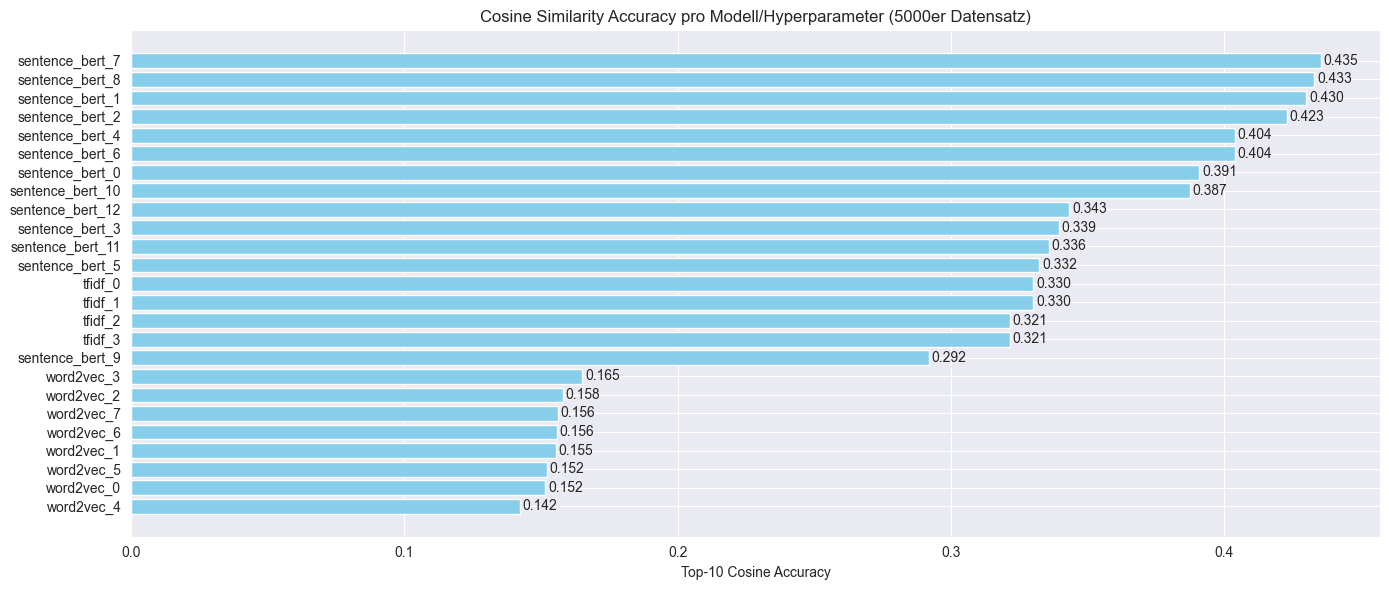

In [7]:
sorted_results = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

labels = [key for key, _ in sorted_results]
scores = [value for _, value in sorted_results]

plt.figure(figsize=(14, 6))
bars = plt.barh(labels, scores, color='skyblue')
plt.xlabel("Top-10 Cosine Accuracy")
plt.title("Cosine Similarity Accuracy pro Modell/Hyperparameter (5000er Datensatz)")
plt.gca().invert_yaxis()

for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f"{score:.3f}", va='center')

plt.tight_layout()
plt.show()


The overall Top-10 hit rate of the tested models is not particularly high. However, it is clear that Sentence-BERT using the `multi-qa-mpnet-base-dot-v1` model performed the best and achieved the highest hit rates.

| Model         | Best Hyperparameters                            | Top-10 Hit Rate |
|---------------|--------------------------------------------------|-----------------|
| Sentence-BERT | model_name = multi-qa-mpnet-base-dot-v1         | 0.435           |
| TF-IDF        | min_df = 3, max_df = 0.7                         | 0.330           |
| Word2Vec      | vector_size = 200, window = 3, min_count = 2     | 0.165           |


## Evaluation and Runtime Comparison

This evaluation compares different vectorization methods in terms of recommendation accuracy and runtime. The goal is to identify approaches that are both efficient and provide precise recommendations.

### Comparison of Methods

The following vectorization methods are tested:

- TF-IDF
- Word2Vec
- Sentence-BERT

These methods are applied to different text sources:

- Overview: Short movie summaries (short texts)
- Plot: Detailed movie descriptions (long texts)

Additionally, two datasets of different sizes are used:

- A dataset with 5,000 movies
- A dataset with 10,000 movies

### Objective of the Analysis

The analysis focuses on two key metrics:

- Runtime of vectorization and similarity calculation
- Top-10 hit rate to evaluate recommendation quality

By combining text source and dataset size, the influence of text length and data volume on runtime and recommendation quality can be analyzed.


In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
runtimes_vectorizer = {}
runtimes_sim = {}
accuracies = {}

def run_vectorization_and_evaluation(name: str, vectorizer_func, data):
    start_vec = time.time()
    vectors = vectorizer_func()
    runtimes_vectorizer[name] = time.time() - start_vec

    similarity = Similarity(vectors)

    start_sim = time.time()
    cosine_sim = similarity.cosine_similarity()
    runtimes_sim[name] = time.time() - start_sim

    accuracies[name] = Accuracy.calculate_accuracy_cosine(data, cosine_sim, top_n=10)



data_sources = {
    "overview5000": recommendation_with_plot_5000['overview'],
    "plot5000": recommendation_with_plot_5000['plot'],
    "overview10000": recommendation_with_plot_10000['overview'],
    "plot10000": recommendation_with_plot_10000['plot']
}

models = {
    "tfidf": lambda vec: vec.tfidf(min_df=3, max_df=0.8, stop_words='english'),
    "word2vec": lambda vec: vec.word2vec(),
    "sentence_bert_mpnet": lambda vec: vec.sentence_bert_embedding(model_name="multi-qa-mpnet-base-dot-v1"),
    "sentence_bert_MiniLM": lambda vec: vec.sentence_bert_embedding(model_name="all-MiniLM-L6-v2"),
}

for source_name, text_data in data_sources.items():
    vectorizer = Vectorizer(text_data, source_name.capitalize())
    for model_name, model_func in models.items():
        key_base = f"{model_name}_{source_name}"
        if "5000" in source_name:
            recommendation_with_plot = recommendation_with_plot_5000
        else:
            recommendation_with_plot = recommendation_with_plot_10000


        run_vectorization_and_evaluation(f"{key_base}", lambda f=model_func: f(vectorizer), recommendation_with_plot)


In [10]:
model_display_names = {
    "tfidf": "TF-IDF",
    "word2vec": "Word2Vec",
    "sentence_bert_mpnet": "Sentence-BERT with MPNET",
    "sentence_bert_MiniLM": "Sentence-BERT with MiniLM"
}

data = {
    "Model": [],
    "Accuracy (%)": [],
    "Runtime Vec (s)": [],
    "Runtime Similarity (s)": [],
    "Source": []
}

def split_key_full(key):
    parts = key.split('_')
    model_key = '_'.join(parts[:-1])
    source = parts[-1]

    return model_key, source


for key in runtimes_vectorizer:
    model_key,source = split_key_full(key)
    data["Model"].append(model_display_names[model_key])
    data["Accuracy (%)"].append(accuracies[key] * 100)
    data["Runtime Vec (s)"].append(runtimes_vectorizer[key])
    data["Runtime Similarity (s)"].append(runtimes_sim[key])
    data["Source"].append(source.capitalize())

df = pd.DataFrame(data)


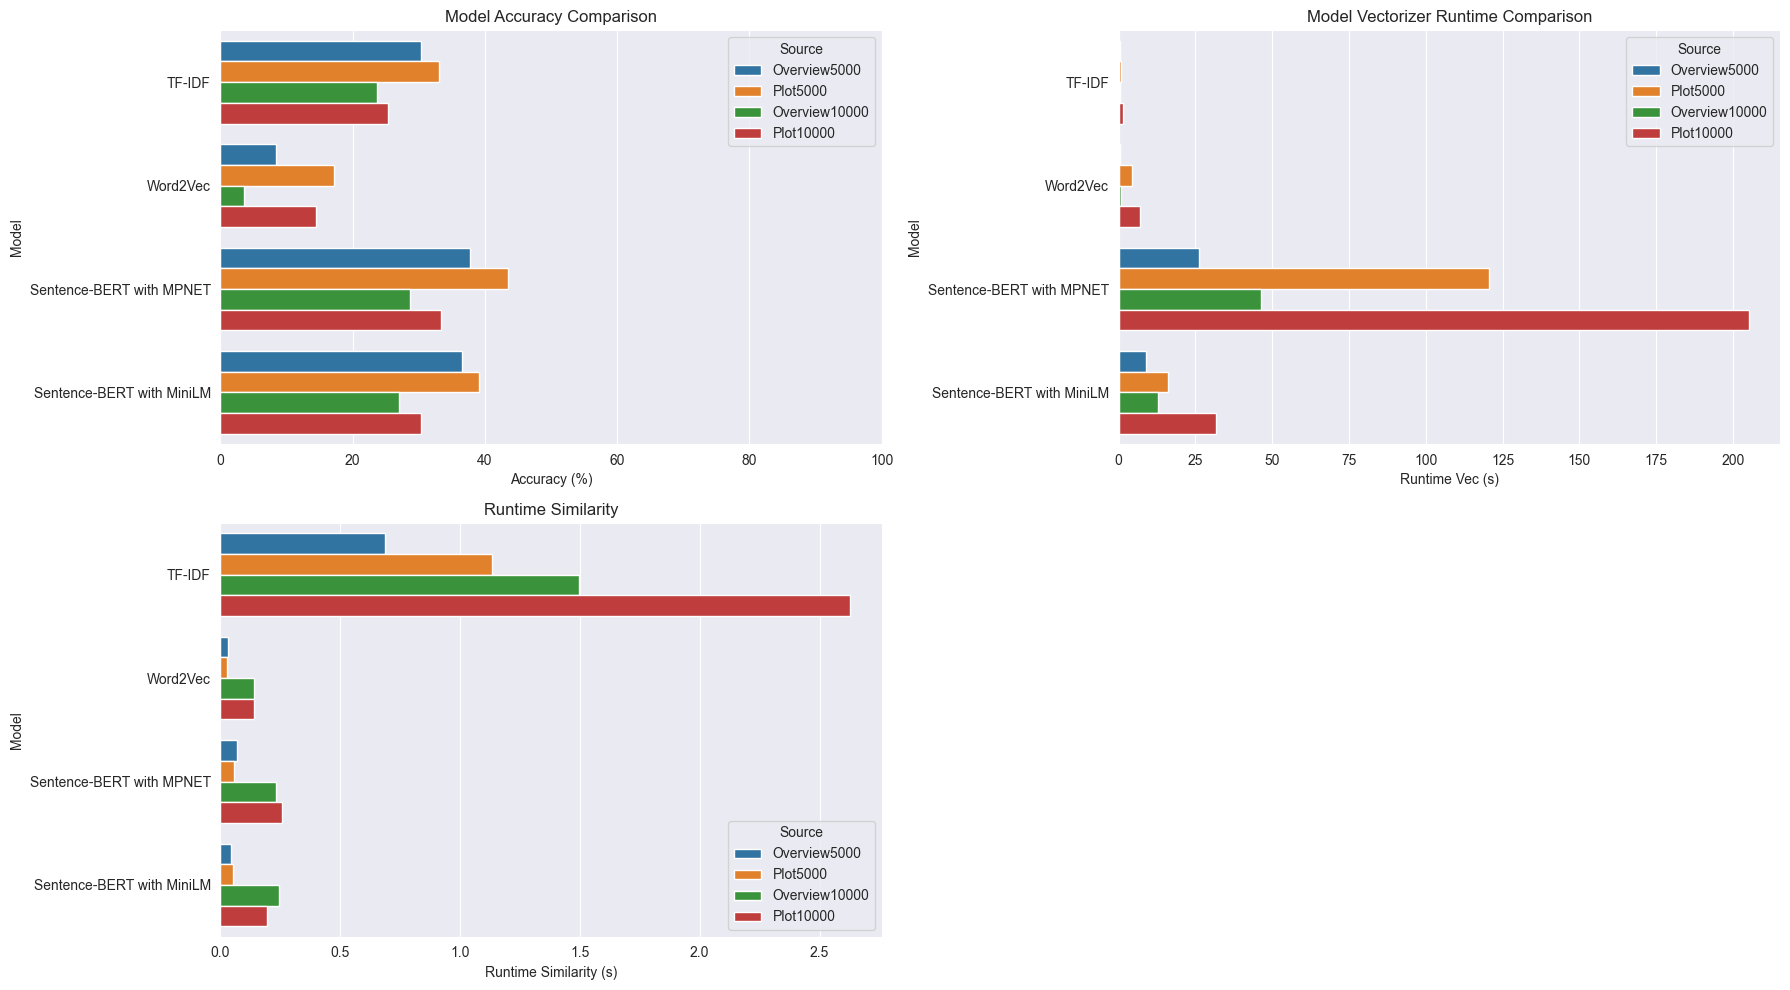

In [11]:
plt.figure(figsize=(18, 10))


plt.subplot(2, 2, 1)
sns.barplot(x="Accuracy (%)", y="Model", hue="Source", data=df)
plt.title("Model Accuracy Comparison")
plt.xlim(0, 100)
plt.legend(title="Source")


plt.subplot(2, 2, 2)
sns.barplot(x="Runtime Vec (s)", y="Model", hue="Source", data=df)
plt.title("Model Vectorizer Runtime Comparison")
plt.legend(title="Source")


plt.subplot(2, 2, 3)
sns.barplot(x="Runtime Similarity (s)", y="Model", hue="Source", data=df)
plt.title("Runtime Similarity")
plt.legend(title="Source")

plt.tight_layout()
plt.show()


In [12]:
df_sorted = df.sort_values(by=["Source", "Accuracy (%)"], ascending=[False, False])
print(df_sorted.to_string(index=False))


                    Model  Accuracy (%)  Runtime Vec (s)  Runtime Similarity (s)        Source
 Sentence-BERT with MPNET     43.513134       120.745518                0.055062      Plot5000
Sentence-BERT with MiniLM     39.081612        15.897302                0.051213      Plot5000
                   TF-IDF     33.005815         0.823784                1.132132      Plot5000
                 Word2Vec     17.184680         4.183586                0.029565      Plot5000
 Sentence-BERT with MPNET     33.410323       205.100138                0.257565     Plot10000
Sentence-BERT with MiniLM     30.357502        31.767484                0.193153     Plot10000
                   TF-IDF     25.286202         1.536496                2.627994     Plot10000
                 Word2Vec     14.520988         6.788749                0.139736     Plot10000
 Sentence-BERT with MPNET     37.698015        26.103355                0.067887  Overview5000
Sentence-BERT with MiniLM     36.534991         8.

### Analysis of the Results

The analysis of the different vectorization methods shows that **Sentence-BERT** overall achieves the best results in terms of **Top-10 hit rate** — reaching a maximum of **43.5%** when using the long plot descriptions (*Plot5000*). However, it should be noted that even this highest value is below 50%, indicating only limited recommendation quality.

**TF-IDF** delivers moderate results with hit rates between **23%** and **33%**, but shows significantly shorter vectorization times and requires overall fewer computational resources. **Word2Vec** consistently achieves the lowest accuracy, in some cases below **10%** .


In [13]:
print(df_sorted[df_sorted['Model'] == 'Sentence-BERT with MPNET'].sort_values("Accuracy (%)", ascending=False).to_string(index=False))

                   Model  Accuracy (%)  Runtime Vec (s)  Runtime Similarity (s)        Source
Sentence-BERT with MPNET     43.513134       120.745518                0.055062      Plot5000
Sentence-BERT with MPNET     37.698015        26.103355                0.067887  Overview5000
Sentence-BERT with MPNET     33.410323       205.100138                0.257565     Plot10000
Sentence-BERT with MPNET     28.660374        46.397995                0.233072 Overview10000


### Sentence-BERT Results Comparison

Focusing exclusively on the results of **Sentence-BERT**, a clear trend emerges: using the **plot description** consistently leads to better hit rates than the shorter **overview description**. For example, *Plot5000* achieves the highest accuracy of **43.5%**, while *Overview5000* reaches **37.7%**. Similarly, *Plot10000* (**33.4%**) outperforms *Overview10000* (**28.7%**).

However, it is also noticeable that the Top-10 hit rate significantly decreases as the dataset size increases (from 5,000 to 10,000 movies), regardless of whether overview or plot descriptions are used. This suggests that recommendation quality declines with larger datasets, possibly because the greater variety of movies makes similarity calculation more challenging.


### Comparison of Cosine Similarity and HNSW Methods

#### Cosine Similarity

Cosine similarity is a measure that calculates the cosine of the angle between two vectors in a high-dimensional space. In the context of movie recommendations, it involves computing the similarity between the embedding vector of a query movie and every other movie embedding in the dataset. This process is **exact** but computationally expensive, as it requires calculating the similarity score for each pairwise combination.

Because cosine similarity performs a **brute-force search** across all movie vectors, its runtime grows linearly with the size of the dataset. When dealing with very large datasets, such as 700,000 movie plots, this approach becomes **prohibitively slow** and impractical for real-time recommendation purposes.

#### HNSW (Hierarchical Navigable Small World)

HNSW is an approximate nearest neighbor search algorithm designed for efficient similarity search in high-dimensional spaces. Instead of exhaustively comparing every vector, HNSW organizes the embeddings into a graph structure that allows for **fast navigation** and retrieval of the nearest neighbors.

This approach significantly **reduces the query time**, typically offering sub-linear runtime complexity relative to the dataset size. While HNSW sacrifices exactness by providing approximate neighbors, it often achieves very similar recommendation quality with **much less computational effort**.

#### Motivation for Using HNSW

Given the large scale of the movie dataset (~500,000 plots), computing exact cosine similarity for all pairs is likely to be **too time-consuming**. To overcome this, the project evaluates whether HNSW can deliver **comparable recommendation accuracy** while substantially **reducing the runtime**.





=== Testing for dataset size: 50000 ===
=== Step 1: Vectorization with SBERT ===
Embeddings shape: (50000, 384)
=== Step 2: Compute full cosine similarity matrix ===
Cosine similarity matrix computed in 12.78 seconds
=== Step 3: Build HNSW index ===
HNSW index built in 17.26 seconds
=== Step 4: Prepare random sample of queries ===
=== Step 5: Search timing comparison on 100 random queries ===
Cosine similarity search time for 100 queries: 0.0906 seconds
HNSW search time for 100 queries: 0.0395 seconds
Average time per query - Cosine: 0.906 ms
Average time per query - HNSW: 0.395 ms

=== Testing for dataset size: 60000 ===
=== Step 1: Vectorization with SBERT ===
Embeddings shape: (60000, 384)
=== Step 2: Compute full cosine similarity matrix ===
Cosine similarity matrix computed in 42.11 seconds
=== Step 3: Build HNSW index ===
HNSW index built in 12.59 seconds
=== Step 4: Prepare random sample of queries ===
=== Step 5: Search timing comparison on 100 random queries ===
Cosine simila

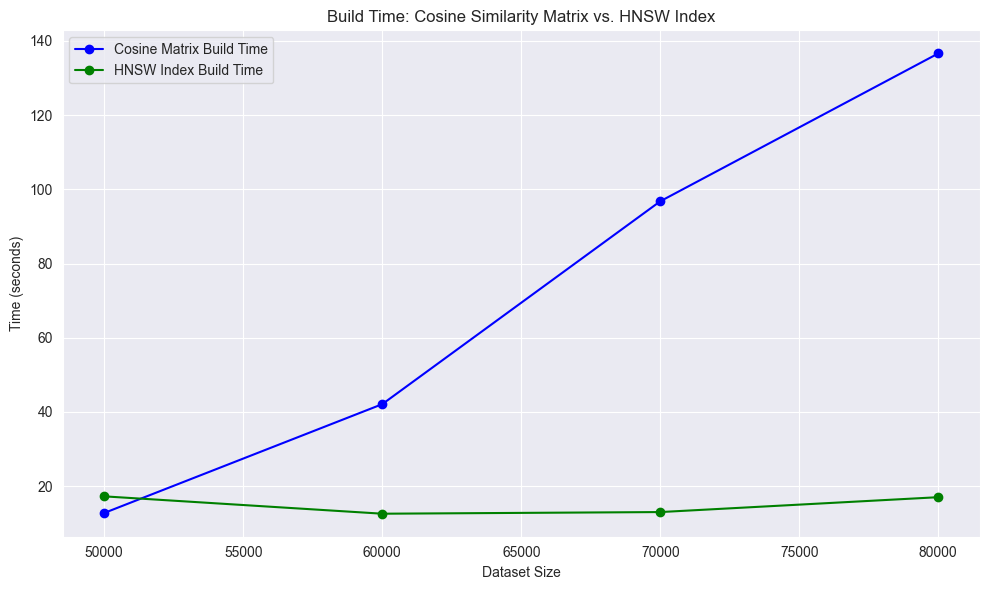

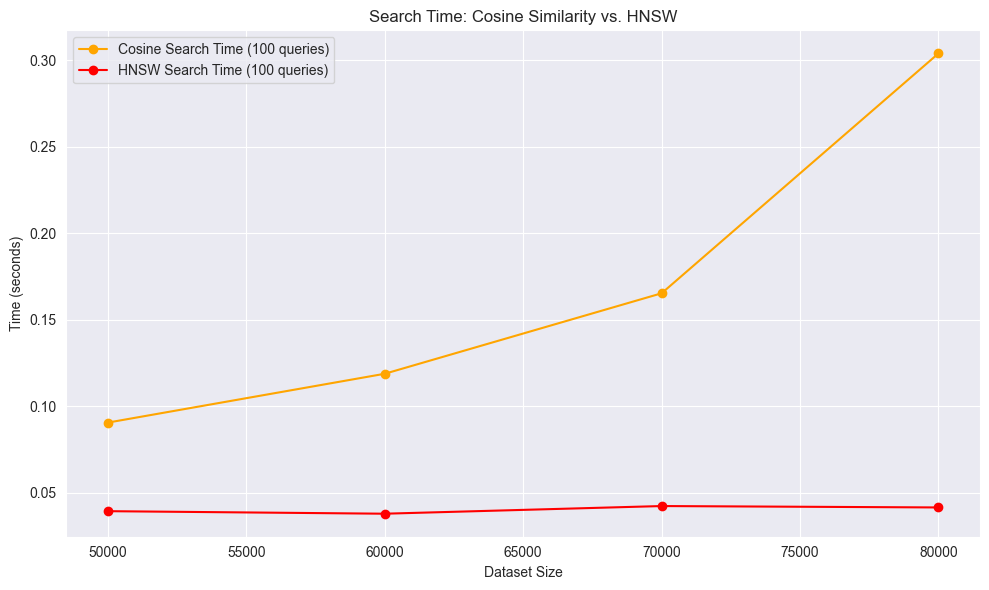

In [14]:
def compare_search_speed(recommendation_df, plot_column='plot', sample_size=100, top_n=10):

    print("=== Step 1: Vectorization with SBERT ===")
    vectorizer = Vectorizer(recommendation_df[plot_column], 'runtime_test_vectorizer')
    embeddings = vectorizer.sentence_bert_embedding()
    num_elements, dim = embeddings.shape
    print(f"Embeddings shape: {embeddings.shape}")

    print("=== Step 2: Compute full cosine similarity matrix ===")
    similarity = Similarity(embeddings)
    start_cosine = time.perf_counter()
    cosine_sim_matrix = similarity.cosine_similarity()
    end_cosine = time.perf_counter()
    print(f"Cosine similarity matrix computed in {end_cosine - start_cosine:.2f} seconds")

    print("=== Step 3: Build HNSW index ===")
    start_hnsw = time.perf_counter()
    hnsw_index = hnswlib.Index(space='cosine', dim=dim)
    hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=16)
    hnsw_index.add_items(embeddings, np.arange(num_elements))
    hnsw_index.set_ef(50)
    end_hnsw = time.perf_counter()
    hnsw_build_time = end_hnsw - start_hnsw
    print(f"HNSW index built in {hnsw_build_time:.2f} seconds")

    print("=== Step 4: Prepare random sample of queries ===")
    random_indices = random.sample(range(num_elements), sample_size)

    print(f"=== Step 5: Search timing comparison on {sample_size} random queries ===")

    def search_cosine(i):
        sims = cosine_sim_matrix[i].copy()
        sims[i] = -1
        top_indices = np.argpartition(sims, -top_n)[-top_n:]
        return top_indices[np.argsort(sims[top_indices])[::-1]]

    def search_hnsw(i):
        labels, distances = hnsw_index.knn_query(embeddings[i], k=top_n + 1)
        filtered = [label for label in labels[0] if label != i]
        return filtered[:top_n]


    start = time.perf_counter()
    for idx in random_indices:
        _ = search_cosine(idx)
    end = time.perf_counter()
    cosine_search_time = end - start


    start = time.perf_counter()
    for idx in random_indices:
        _ = search_hnsw(idx)
    end = time.perf_counter()
    hnsw_search_time = end - start

    print(f"Cosine similarity search time for {sample_size} queries: {cosine_search_time:.4f} seconds")
    print(f"HNSW search time for {sample_size} queries: {hnsw_search_time:.4f} seconds")

    print(f"Average time per query - Cosine: {cosine_search_time/sample_size*1000:.3f} ms")
    print(f"Average time per query - HNSW: {hnsw_search_time/sample_size*1000:.3f} ms")

    return {
        'num_elements': num_elements,
        'cosine_matrix_build': end_cosine - start_cosine,
        'hnsw_index_build': hnsw_build_time,
        'cosine_search_total': cosine_search_time,
        'hnsw_search_total': hnsw_search_time,
        'cosine_search_avg_ms': cosine_search_time / sample_size * 1000,
        'hnsw_search_avg_ms': hnsw_search_time / sample_size * 1000
    }

sample_sizes = [50000, 60000, 70000, 80000]
results_list = []

for size in sample_sizes:
    print(f"\n=== Testing for dataset size: {size} ===")
    df_sample = df_all.sample(n=size).reset_index(drop=True)
    df_sample['plot'] = df_sample['plot'].astype(str)
    result = compare_search_speed(df_sample, sample_size=100, top_n=10)
    results_list.append(result)

sizes = [r['num_elements'] for r in results_list]
cosine_build_times = [r['cosine_matrix_build'] for r in results_list]
hnsw_build_times = [r['hnsw_index_build'] for r in results_list]
cosine_search_times = [r['cosine_search_total'] for r in results_list]
hnsw_search_times = [r['hnsw_search_total'] for r in results_list]


plt.figure(figsize=(10, 6))
plt.plot(sizes, cosine_build_times, label='Cosine Matrix Build Time', marker='o', color='blue')
plt.plot(sizes, hnsw_build_times, label='HNSW Index Build Time', marker='o', color='green')
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Build Time: Cosine Similarity Matrix vs. HNSW Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sizes, cosine_search_times, label='Cosine Search Time (100 queries)', marker='o', color='orange')
plt.plot(sizes, hnsw_search_times, label='HNSW Search Time (100 queries)', marker='o', color='red')
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Search Time: Cosine Similarity vs. HNSW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:
vec_acc_test = Vectorizer(recommendation_with_plot_5000['plot'], 'Acc Test')
embedding = vec_acc_test.sentence_bert_embedding()

sim = Similarity(embedding)
labels, distances = sim.hnsw_similarity(10)
cos_sim = sim.cosine_similarity()

accuracies_hsnw = Accuracy.calculate_accuracy_hsnw(recommendation_with_plot_5000, labels)
accuracies_cos_sim = Accuracy.calculate_accuracy_cosine(recommendation_with_plot_5000, cos_sim)


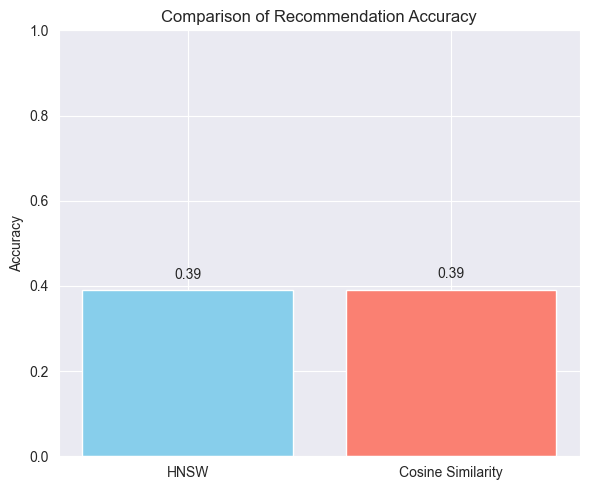

In [16]:
accuracies = [accuracies_hsnw, accuracies_cos_sim]
labels = ['HNSW', 'Cosine Similarity']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Recommendation Accuracy')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Result

The time required for cosine similarity increases significantly, while HNSW only grows moderately. The same trend can be observed in the search time for both methods. When testing whether HNSW loses accuracy compared to cosine similarity, it was found that the accuracy remained the same. Since HNSW is significantly faster with equal accuracy, it will be the preferred choice for the application.


### Analysis of Genre Separation in Vector Space Using Sentence-BERT and t-SNE

The previous results suggest that generating precise recommendations solely based on content similarity is likely challenging. This is because movie recommendations often rely on more than just content descriptions. To better evaluate the model, an analysis is performed to check whether it meaningfully separates thematically similar movies, especially regarding their genres.

For this purpose, the quality of genre separation in the generated vectors is examined. The assumption is that movies from different genres — for example, “Romance” and “War” — differ significantly in content and should thus be located far apart in the embedding space. Selected main genres (e.g., “War,” “Action,” “Comedy,” “Family,” “Romance”) are filtered and converted into vectors using the Sentence-BERT model. Then, the high-dimensional embeddings are reduced to two dimensions with t-SNE to visually illustrate the distribution.

The goal is to investigate whether movies of the same genre cluster together and whether distinct genres are clearly separated. A clear separation would indicate that the model is capable of capturing genre-specific content effectively.


In [17]:
recommendation_with_plot_5000['main_genre'] = recommendation_with_plot_5000['genres'].str.split('-').str[0]

target_genres = ['War', 'Action', 'Comedy', 'Family', 'Romance']
filtered_df = recommendation_with_plot_5000[recommendation_with_plot_5000['main_genre'].isin(target_genres)]


In [18]:
vectorizer = Vectorizer(filtered_df['plot'].reset_index(drop=True), "filtered_plots")
embedding = vectorizer.sentence_bert_embedding()

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, learning_rate='auto', init='pca', random_state=42)
embedding_2d = tsne.fit_transform(embedding)

label_encoder = LabelEncoder()
genre_labels = label_encoder.fit_transform(filtered_df['main_genre'])
genre_names = label_encoder.classes_

plot_df = pd.DataFrame({
    'TSNE-1': embedding_2d[:, 0],
    'TSNE-2': embedding_2d[:, 1],
    'Genre': filtered_df['main_genre'].values,
    'Title': filtered_df['title'].values
})

fig = px.scatter(
    plot_df,
    x='TSNE-1',
    y='TSNE-2',
    color='Genre',
    hover_name='Title',
    title="Embedding Genre Analysis",
    width=1000,
    height=800
)

fig.update_layout(legend_title_text='Genres')
fig.show()


Python(14997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Analysis of Genre Separation in Vector Space Using Sentence-BERT and t-SNE

The t-SNE visualization of the Sentence-BERT embeddings clearly shows that the model is capable of meaningfully structuring movies in the vector space based on their content descriptions. Particularly noticeable is the clear separation between **Action** and **Comedy** — two genres with very distinct thematic focuses. This demonstrates that the model reliably identifies coarse genre boundaries.

At the same time, **Romance** and **Family** are partially mixed with **Comedy**. A certain closeness can also be observed between **Action** and **War**. This indicates that the model correctly captures content similarities. Romance movies often contain humorous elements, as do family films. War movies frequently feature action-packed scenes. That these genres are therefore closer or overlap in the vector space is a sign of a functioning semantic representation.

The combination of clear separations and meaningful overlaps suggests that the model recognizes relevant content structures. This implies that Sentence-BERT is fundamentally suitable for generating movie recommendations based on content similarity.


### Analysis of Additional Features to Improve Recommendations

To investigate whether additional numerical features from the dataset can be used to enhance recommendation quality, a **correlation analysis** is conducted between recommended movies and their original counterparts. The following features are the focus of this analysis: `popularity`, `budget`, `revenue`, `runtime`, `vote_average`, and `vote_count`.

For each feature, the degree to which the values of the recommended movies align with those of the corresponding original movies is examined. A high correlation could indicate that these features might be effectively incorporated to improve the Top-10 hit rate.


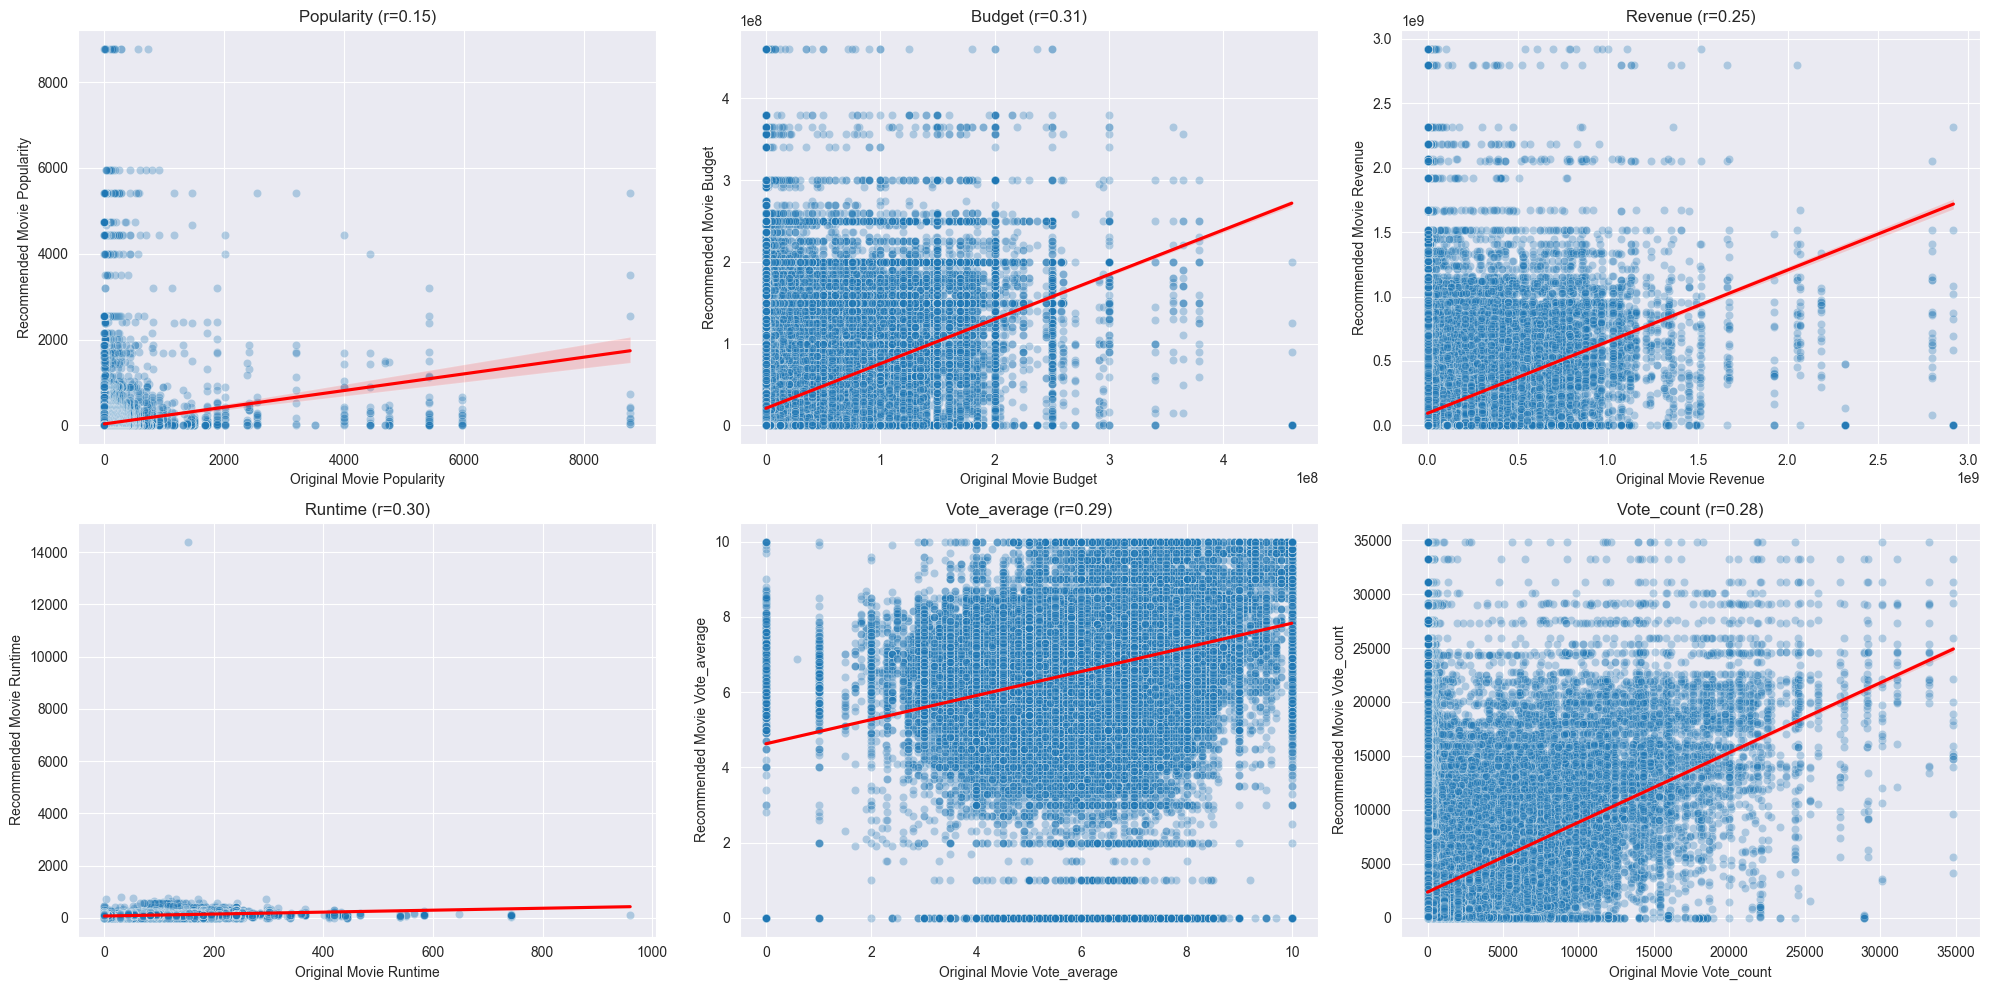

In [19]:
def collect_feature_pairs(df, feature):
    id_to_movie = df.set_index('id').to_dict(orient='index')

    original_vals = []
    recommended_vals = []

    for _, row in df.iterrows():
        rec_ids = str(row['recommendations']).split('-')
        rec_ids = [int(r) for r in rec_ids if r.isdigit() and int(r) in id_to_movie]
        if not rec_ids:
            continue

        original_value = row[feature]

        for rec_id in rec_ids:
            recommended_value = id_to_movie[rec_id][feature]
            if pd.notna(original_value) and pd.notna(recommended_value):
                original_vals.append(original_value)
                recommended_vals.append(recommended_value)

    return original_vals, recommended_vals

features = ['popularity', 'budget', 'revenue', 'runtime', 'vote_average', 'vote_count']

fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 3 columns
axes = axes.flatten()

for idx, feat in enumerate(features):
    orig, rec = collect_feature_pairs(df_all.copy(), feat)
    corr, pval = stats.pearsonr(orig, rec)

    sns.scatterplot(x=orig, y=rec, alpha=0.3, ax=axes[idx])
    sns.regplot(x=orig, y=rec, scatter=False, color='red', ax=axes[idx])
    axes[idx].set_xlabel(f'Original Movie {feat.capitalize()}')
    axes[idx].set_ylabel(f'Recommended Movie {feat.capitalize()}')
    axes[idx].set_title(f'{feat.capitalize()} (r={corr:.2f})')

plt.tight_layout()
plt.show()


### Correlation Analysis: Low Associations Between Numerical Features

The conducted analysis examines whether certain numerical features of the original movies correlate with those of the recommended movies. The **Pearson correlation coefficient** is used, which ranges from **-1 to +1**:

| Correlation Coefficient (r) | Interpretation                      |
|-----------------------------|-----------------------------------|
| 0.00 – 0.10                 | No to very weak correlation       |
| 0.10 – 0.30                 | Weak correlation                  |
| 0.30 – 0.50                 | Moderate correlation              |
| 0.50 – 0.70                 | Strong correlation                |
| 0.70 – 1.00                 | Very strong correlation           |

In this analysis, the highest observed correlation value is **r = 0.31** for the feature **budget**. This corresponds to a **moderate but borderline weak correlation**. The other features such as `popularity`, `revenue`, `runtime`, `vote_average`, and `vote_count` show **even lower values**—mostly below 0.2—indicating **no or very weak associations**.

Overall, these results suggest that the numerical attributes of the movies **are not strongly related to the selection of recommended movies**. Due to the low correlations and the associated low likelihood of significant improvement, extending the model with these numerical features is **not pursued further**.


## Recommender Application

Despite the relatively low Top-10 hit rate, we aim to develop a web application for our recommendation system. The system recommends similar movies within the same or related genres, providing users with valuable and relevant suggestions.

We rely on an SBERT-based model for recommendations, as it has proven effective in comparing movies based on their content descriptions. Specifically, we use the **plot** — the longer textual description of a movie — since it performed better in our tests.

The model is trained on a large dataset of over 500,000 movies.


In [3]:
import os
import numpy as np
import pandas as pd
import hnswlib
from sentence_transformers import SentenceTransformer


class MovieRecommenderSBERT:
    def __init__(
            self,
            df: pd.DataFrame,
            text_column: str = "plot",
            model_name: str = "all-MiniLM-L6-v2",
            embedding_path: str | None = "embeddings.npy",
            index_path: str | None = "hnsw_index.bin",
    ):
        self.df = df.reset_index(drop=True).copy()   # Reihenfolge fixieren
        self.text_column = text_column
        self.model = SentenceTransformer(model_name)

        # --- 1) Embeddings laden oder neu berechnen -------------------------
        if embedding_path and os.path.isfile(embedding_path):
            print("Lade Embeddings aus", embedding_path)
            self.embeddings = np.load(embedding_path)
        else:
            print("Berechne Embeddings")
            texts = self.df[text_column].astype(str).tolist()
            self.embeddings = self.model.encode(
                texts,
                convert_to_numpy=True,
                normalize_embeddings=True,
                show_progress_bar=True,
            )
            if embedding_path:
                np.save(embedding_path, self.embeddings)
                print("Embeddings gespeichert nach", embedding_path)

        # --- 2) HNSW-Index laden oder neu aufbauen --------------------------
        dim = self.embeddings.shape[1]
        self.index = hnswlib.Index(space="cosine", dim=dim)

        if index_path and os.path.isfile(index_path):
            print("Lade HNSW-Index aus", index_path)
            self.index.load_index(index_path)
            self.index.set_ef(50)
        else:
            print("Baue neuen HNSW-Index …")
            self.index.init_index(
                max_elements=self.embeddings.shape[0],
                ef_construction=200,
                M=16,
            )
            # IDs 0..n-1 passen zur DataFrame-Reihenfolge
            self.index.add_items(self.embeddings, ids=np.arange(len(self.embeddings)))
            self.index.set_ef(50)
            if index_path:
                self.index.save_index(index_path)
                print("HNSW-Index gespeichert nach", index_path)

    # -----------------------------------------------------------------------
    def recommend(self, input_text: str, top_n: int = 10) -> pd.DataFrame:
        input_embedding = self.model.encode(
            [input_text],
            convert_to_numpy=True,
            normalize_embeddings=True,
        )
        labels, distances = self.index.knn_query(input_embedding, k=top_n)

        result = self.df.iloc[labels[0]].copy()
        result["similarity"] = 1 - distances[0]
        return result.reset_index(drop=True)


In [4]:
df_all = pd.read_json("../data/all_data.json", lines=True)

recommender = MovieRecommenderSBERT(
    df_all[["id", "title", "plot", "poster_path"]],
    embedding_path="movie_emb.npy",
    index_path="movie_index.bin",
)



Lade Embeddings aus movie_emb.npy
Lade HNSW-Index aus movie_index.bin


In [5]:
df_all.head(5)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,...,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,plot
0,615656,meg 2: the trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000,352056482,...,Back for seconds.,7.079,1365,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...,2023,An exploratory dive into the deepest depths of...
1,758323,the pope's exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000,65675816,...,Inspired by the actual files of Father Gabriel...,7.433,545,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...,2023,Father Gabriele Amorth Chief Exorcist of the V...
2,533535,deadpool & wolverine,Action-Comedy-Science Fiction,en,A listless Wade Wilson toils away in civilian ...,5410.496,Marvel Studios-Maximum Effort-21 Laps Entertai...,2024-07-24,200000000,1326387384,...,Come together.,7.765,3749,Ryan Reynolds-Hugh Jackman-Emma Corrin-Matthew...,hero-superhero-anti hero-mutant-breaking the f...,/8cdWjvZQUExUUTzyp4t6EDMubfO.jpg,/dvBCdCohwWbsP5qAaglOXagDMtk.jpg,573435-519182-957452-1022789-945961-718821-103...,2024,A listless Wade Wilson toils away in civilian ...
3,667538,transformers: rise of the beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000,407045464,...,Unite or fall.,7.340,1007,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...,2023,When a new threat capable of destroying the en...
4,693134,dune: part two,Science Fiction-Adventure,en,Follow the mythic journey of Paul Atreides as ...,4742.163,Legendary Pictures,2024-02-27,190000000,683813734,...,Long live the fighters.,8.300,2770,Timothée Chalamet-Zendaya-Rebecca Ferguson-Jav...,epic-based on novel or book-fight-sandstorm-sa...,/czembW0Rk1Ke7lCJGahbOhdCuhV.jpg,/xOMo8BRK7PfcJv9JCnx7s5hj0PX.jpg,438631-763215-792307-1011985-467244-634492-359...,2024,Follow the mythic journey of Paul Atreides as ...


### Quick Test of Recommendation Quality Using "Harry Potter"

To verify the quality of the recommendations, we use the movie "Harry Potter" as an example. We input the plot of the first Harry Potter film into our recommendation system and expect that primarily other parts of the Harry Potter series will be suggested as similar movies.


In [6]:
harry_potter_movie = df_all.loc[
    df_all["title"].str.contains("harry potter", case=False, na=False),
    ["id", "title", "plot"]
].iloc[0]

user_query = harry_potter_movie["plot"]

recommendations = recommender.recommend(user_query, top_n=10)

print(recommendations[["title", "similarity"]])

                                          title  similarity
0           harry potter and the goblet of fire    1.000000
1      harry potter and the prisoner of azkaban    0.584719
2     harry potter and the order of the phoenix    0.560955
3       harry potter and the chamber of secrets    0.547377
4      harry potter and the philosopher's stone    0.518724
5                           lloyd the conqueror    0.486568
6                                       houdini    0.479964
7  harry potter and the deathly hallows: part 1    0.471791
8  harry potter and the deathly hallows: part 2    0.467564
9        harry potter and the half-blood prince    0.461047


### Web Application for Movie Recommendations

For demonstrating the recommendation system, a simple web application was created using Flask. This application allows users to receive suitable movie recommendations based on a selected film.

The application runs locally and automatically opens a webpage in the browser where the recommendations can be tested.


In [7]:
app = Flask(__name__)

@app.route('/')
def home():
    page = int(request.args.get('page', 1))
    per_page = 20
    start = (page - 1) * per_page
    end = start + per_page
    movies = df_all.iloc[start:end].to_dict(orient='records')
    return render_template('home.html', movies=movies, page=page)

@app.route('/movie/<int:movie_id>')
def movie(movie_id):
    movie = df_all[df_all['id'] == movie_id].iloc[0]
    recommendations = recommender.recommend(movie['plot'], top_n=10)
    return render_template('recommendations.html', movie=movie, recommendations=recommendations.to_dict(orient='records'))

def run_app():
    app.run(port=5002, debug=False, use_reloader=False)

thread = Thread(target=run_app)
thread.daemon = True
thread.start()


time.sleep(1)
webbrowser.open("http://localhost:5002")


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit


True

## Conclusion and future work
### Conclusion — addressing RQ-2
*Which text-representation strategy yields the best performance for the recommendation system?*

We compared three vectorisation approaches, **TF-IDF**, **Word2Vec**, and **Sentence-BERT**, within our content-based movie recommender.
Across all evaluation runs, **Sentence-BERT consistently delivered the highest Top-10 hit rate**, clearly outperforming the two bag-of-words baselines.

Longer plot summaries further improved recommendation quality, presumably because the richer context helps Sentence-BERT capture finer-grained semantic relationships.
While overall accuracy remains moderate, the system reliably suggests movies that fall into the same or closely related genres.



### Future Work

While the current system provides a solid foundation, there are several promising directions for improvement. One approach is to implement hybrid recommender systems, which combine content-based filtering (based on text embeddings) with collaborative filtering methods that leverage user behavior, such as ratings or viewing history. This combination can lead to more accurate and personalized recommendations.


